## A. Multiple Choice (20 points)

In [1]:
from PIL import Image
import numpy as np
import cv2

x, y = 10,10
data = np. zeros((x, y), dtype=np. uint8)
data[:][:] = 255
data[1][2:7] = 0
data[2][1:3] = 0
data[3][1:3] = 0
data[2][6:9] = 0
data[3][7:9] = 0
data[4][1:5] = 0
data[4][7] = 0
data[5][1] = 0
data[5][4:8] = 0
data[6][1] = 0
data[6][7:9] = 0
data[7][1:4] = 0
data[7][6:9] = 0
data[8][3:8] = 0
cv2.imwrite('sample.jpg',data) 

kernel = np.ones((2,2), np.uint8)
erosion = cv2.erode(data, kernel, iterations = 1)

cv2.imwrite('erosion.jpg',erosion)


True

## B. Find the Contour (20 points)

In [3]:
import cv2  
 
img = cv2.imread("SingleRice.jpg")  
 
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
blur = cv2.GaussianBlur(gray, (101, 101), 0)
ret, binary = cv2.threshold(blur,70,200,cv2.THRESH_BINARY)  
 
contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
cv2.drawContours(img,contours,-1,(0,0,255),3)  
cv2.imwrite('SingleRice_contours.jpg',img) 
cv2.imwrite('SingleRice_blur.jpg',blur) 

True

## C. Image Enhancement (25 points)

/Users/570/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3526: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


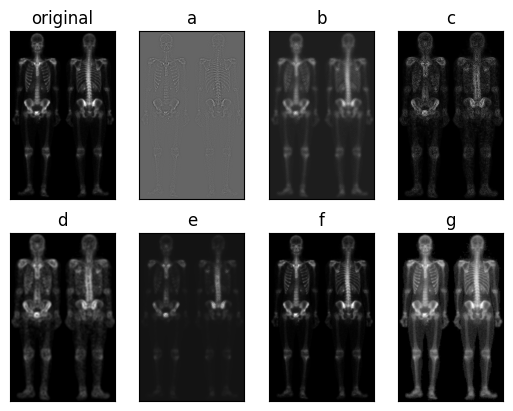

In [2]:
import skimage
from skimage import img_as_float
import matplotlib.pyplot as plt
from skimage import filters
from skimage.morphology import square
import numpy as np
import cv2

img = img_as_float(skimage.io.imread('Xray.png'))
laplacian = filters.laplace(img.copy())
sharpen = img - laplacian
sobel = filters.sobel(sharpen)
mean = img_as_float(filters.rank.mean(sobel, square(width=5)))
multilpy = sharpen * mean
shar = img + multilpy
result = np.sqrt(shar)


plt.subplot(2, 4, 1)
plt.title('original'), plt.xticks([]), plt.yticks([])
plt.imshow(img, cmap='gray')
plt.subplot(2, 4, 2)
plt.title('a'), plt.xticks([]), plt.yticks([])
plt.imshow(laplacian, cmap='gray')
plt.subplot(2, 4, 3)
plt.title('b'), plt.xticks([]), plt.yticks([])
plt.imshow(sharpen, cmap='gray')
plt.subplot(2, 4, 4)
plt.title('c'), plt.xticks([]), plt.yticks([])
plt.imshow(sobel, cmap='gray')
plt.subplot(2, 4, 5)
plt.title('d'), plt.xticks([]), plt.yticks([])
plt.imshow(mean, cmap='gray')
plt.subplot(2, 4, 6)
plt.title('e'), plt.xticks([]), plt.yticks([])
plt.imshow(multilpy, cmap='gray')
plt.subplot(2, 4, 7)
plt.title('f'), plt.xticks([]), plt.yticks([])
plt.imshow(shar, cmap='gray')
plt.subplot(2, 4, 8)
plt.title('g'), plt.xticks([]), plt.yticks([])
plt.imshow(result, cmap='gray')

plt.show()

## D. FingerprintAnalysis(35points)

In [ ]:
import skimage
from skimage.morphology import skeletonize, thin, medial_axis
import skimage.morphology
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
from scipy import ndimage
from scipy import signal
import scipy


def getTerminationBifurcation(img, mask):
    img = img == 255
    (rows, cols) = img.shape
    minutiaeTerm = np.zeros(img.shape)
    minutiaeBif = np.zeros(img.shape)
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if(img[i][j] == 1):
                block = img[i-1:i+2, j-1:j+2]
                block_val = np.sum(block)
                if(block_val == 2):
                    minutiaeTerm[i, j] = 1
                elif(block_val == 4):
                    minutiaeBif[i, j] = 1
    
    mask = convex_hull_image(mask>0)
    # cv2.imshow('a', minutiaeTerm)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    mask = erosion(mask, square(5))         
    minutiaeTerm = np.uint8(mask)*minutiaeTerm
    return(minutiaeTerm, minutiaeBif)

def removeSpuriousMinutiae(minutiaeList, img, thresh):
    img = img * 0
    SpuriousMin = []
    numPoints = len(minutiaeList)
    D = np.zeros((numPoints, numPoints))
    sumX = minutiaeList[0]['centroid'][0]
    sumY = minutiaeList[0]['centroid'][1]
    for i in range(1,numPoints):
        sumX = sumX + minutiaeList[i]['centroid'][0]
        sumY = sumY + minutiaeList[i]['centroid'][1]
        for j in range(0, i):
            (X1,Y1) = minutiaeList[i]['centroid']
            (X2,Y2) = minutiaeList[j]['centroid']
            
            dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2)
            D[i][j] = dist
            if(dist < thresh):
                SpuriousMin.append(i)
                SpuriousMin.append(j)
                
    for i in range(numPoints):
        (X, Y) = minutiaeList[i]['centroid']
        # dist = np.sqrt((X-(sumX/numPoints))**2 + (Y-(sumY/numPoints))**2)
        # if dist > 170:
        #     SpuriousMin.append(i)
        if abs(X-(sumX/numPoints)) > 152.5:
            SpuriousMin.append(i)
        elif abs(Y-(sumY/numPoints)) > 128:
            SpuriousMin.append(i)
    SpuriousMin = np.unique(SpuriousMin)
    
    for i in range(0,numPoints):
        if(not i in SpuriousMin):
            (X,Y) = np.int16(minutiaeList[i]['centroid'])
            img[X,Y] = 1
    
    img = np.uint8(img)
    return(img)


def ShowResults(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0
    minutiaeTerm = BifLabel * 0

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel
    DispImg[:, :, 1] = skel
    DispImg[:, :, 2] = skel

    RP = skimage.measure.regionprops(BifLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 10)
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))

    RP = skimage.measure.regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 10)
        skimage.draw.set_color(DispImg, (rr, cc), (0, 255, 0))

    return DispImg

class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

def computeAngle(block, minutiaeType):
    (blkRows, blkCols) = np.shape(block)
    CenterX, CenterY = (blkRows-1)/2, (blkCols-1)/2
    angle = 0
    if(minutiaeType.lower() == 'termination'):
        sumVal = 0
        for i in range(blkRows):
            for j in range(blkCols):
                if((i == 0 or i == blkRows-1 or j == 0 or j == blkCols-1) and block[i][j] != 0):
                    angle = -math.degrees(math.atan2(i-CenterY, j-CenterX))
                    sumVal += 1
                    if(sumVal > 1):
                        angle = float('nan')
        return(angle)
    elif(minutiaeType.lower() == 'bifurcation'):
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        angle = []
        sumVal = 0
        for i in range(blkRows):
            for j in range(blkCols):
                if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                    angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                    sumVal += 1
        if(sumVal != 3):
            angle = float('nan')
        return(angle)


def extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif):
    FeaturesTerm = []

    minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2)
    RP = skimage.measure.regionprops(minutiaeTerm)
    
    WindowSize = 2          # --> For Termination, the block size must can be 3x3, or 5x5. Hence the window selected is 1 or 2
    FeaturesTerm = []
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        ex_angle = computeAngle(block, 'Termination')
        FeaturesTerm.append(MinutiaeFeature(row, col, ex_angle, 'Termination'))

    FeaturesBif = []
    minutiaeBif = skimage.measure.label(minutiaeBif, connectivity=2)
    RP = skimage.measure.regionprops(minutiaeBif)
    WindowSize = 1          # --> For Bifurcation, the block size must be 3x3. Hence the window selected is 1
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        ex_angle = computeAngle(block, 'Bifurcation')
        FeaturesBif.append(MinutiaeFeature(row, col, ex_angle, 'Bifurcation'))
    return(FeaturesTerm, FeaturesBif)

# def normalise(img,mean,std):
#     normed = (img - np.mean(img))/(np.std(img))
#     return(normed)
    
def ridge_segment(im, blksze, thresh):
    
    rows, cols = im.shape
    im = skimage.exposure.equalize_hist(im)
    
    new_rows =  np.int(blksze * np.ceil((np.float(rows))/(np.float(blksze))))
    new_cols =  np.int(blksze * np.ceil((np.float(cols))/(np.float(blksze))))
    
    padded_img = np.zeros((new_rows,new_cols))
    stddevim = np.zeros((new_rows,new_cols))
    
    padded_img[0:rows][:,0:cols] = im
    
    for i in range(0, new_rows, blksze):
        for j in range(0, new_cols, blksze):
            block = padded_img[i:i+blksze][:,j:j+blksze]
            
            stddevim[i:i+blksze][:,j:j+blksze] = np.std(block)*np.ones(block.shape)
    
    stddevim = stddevim[0:rows][:,0:cols]
                    
    mask = stddevim > thresh
    
    mean_val = np.mean(im[mask])
    std_val = np.std(im[mask])
    normim = (im - mean_val)/(std_val)
    
    return(normim, mask)

def ridge_orient(im, gradientsigma, blocksigma, orientsmoothsigma):
    rows, cols = im.shape
    #Calculate image gradients.
    sze = np.fix(6 * gradientsigma)
    if np.remainder(sze, 2) == 0:
        sze = sze+1
        
    gauss = cv2.getGaussianKernel(np.int(sze),gradientsigma)
    f = gauss * gauss.T
    
    fy, fx = np.gradient(f)
    Gx = signal.convolve2d(im, fx, mode='same')
    Gy = signal.convolve2d(im, fy, mode='same')
    
    Gxx = np.power(Gx,2)
    Gyy = np.power(Gy,2)
    Gxy = Gx*Gy
    
    #Now smooth the covariance data to perform a weighted summation of the data.    
    
    sze = np.fix(6*blocksigma)
    
    gauss = cv2.getGaussianKernel(np.int(sze),blocksigma)
    f = gauss * gauss.T
    
    Gxx = ndimage.convolve(Gxx,f)
    Gyy = ndimage.convolve(Gyy,f)
    Gxy = 2*ndimage.convolve(Gxy,f)
    
    # Analytic solution of principal direction
    denom = np.sqrt(np.power(Gxy,2) + np.power((Gxx - Gyy),2)) + np.finfo(float).eps
    
    sin2theta = Gxy/denom       # Sine and cosine of doubled angles
    cos2theta = (Gxx-Gyy)/denom
    
    
    if orientsmoothsigma:
        sze = np.fix(6*orientsmoothsigma)
        if np.remainder(sze,2) == 0:
            sze = sze+1
        gauss = cv2.getGaussianKernel(np.int(sze),orientsmoothsigma)
        f = gauss * gauss.T
        cos2theta = ndimage.convolve(cos2theta,f) # Smoothed sine and cosine
        sin2theta = ndimage.convolve(sin2theta,f) # doubled angles
    
    orientim = np.pi/2 + np.arctan2(sin2theta,cos2theta)/2
    return(orientim)

def frequest(im,orientim,windsze,minWaveLength,maxWaveLength):
    rows, cols = np.shape(im)
    
    # Find mean orientation within the block. This is done by averaging the
    # sines and cosines of the doubled angles before reconstructing the
    # angle again.  This avoids wraparound problems at the origin.
        
    
    cosorient = np.mean(np.cos(2*orientim))
    sinorient = np.mean(np.sin(2*orientim))  
    orient = math.atan2(sinorient,cosorient)/2
    
    # Rotate the image block so that the ridges are vertical    
    rotim = scipy.ndimage.rotate(im,orient/np.pi*180 + 90,axes=(1,0),reshape = False,order = 3,mode = 'nearest')

    # Now crop the image so that the rotated image does not contain any
    # invalid regions.  This prevents the projection down the columns
    # from being mucked up.
    
    cropsze = int(np.fix(rows/np.sqrt(2)))
    offset = int(np.fix((rows-cropsze)/2))
    rotim = rotim[offset:offset+cropsze][:,offset:offset+cropsze]
    
    # Sum down the columns to get a projection of the grey values down
    # the ridges.
    
    proj = np.sum(rotim,axis = 0)
    dilation = scipy.ndimage.grey_dilation(proj, windsze,structure=np.ones(windsze))

    temp = np.abs(dilation - proj)
    
    peak_thresh = 2
    
    maxpts = (temp<peak_thresh) & (proj > np.mean(proj))
    maxind = np.where(maxpts)
    
    rows_maxind,cols_maxind = np.shape(maxind)
    
    if(cols_maxind<2):
        freqim = np.zeros(im.shape)
    else:
        NoOfPeaks = cols_maxind
        waveLength = (maxind[0][cols_maxind-1] - maxind[0][0])/(NoOfPeaks - 1)
        if waveLength>=minWaveLength and waveLength<=maxWaveLength:
            freqim = 1/np.double(waveLength) * np.ones(im.shape)
        else:
            freqim = np.zeros(im.shape)
        
    return(freqim)

def ridge_freq(im, mask, orient, blksze, windsze,minWaveLength, maxWaveLength):
    rows,cols = im.shape
    freq = np.zeros((rows,cols))
    
    for r in range(0,rows-blksze,blksze):
        for c in range(0,cols-blksze,blksze):
            blkim = im[r:r+blksze][:,c:c+blksze]
            blkor = orient[r:r+blksze][:,c:c+blksze]
            freq[r:r+blksze][:,c:c+blksze] = frequest(blkim,blkor,windsze,minWaveLength,maxWaveLength)
    
    freq = freq*mask
    freq_1d = np.reshape(freq,(1,rows*cols))
    ind = np.where(freq_1d>0)
    
    ind = np.array(ind)
    ind = ind[1,:]
    
    non_zero_elems_in_freq = freq_1d[0][ind]   
    
    meanfreq = np.mean(non_zero_elems_in_freq)
    medianfreq = np.median(non_zero_elems_in_freq)
    return(freq,meanfreq)

def ridge_filter(im, orient, freq, kx, ky):
    angleInc = 3
    im = np.double(im)
    rows,cols = im.shape
    newim = np.zeros((rows,cols))
    
    freq_1d = np.reshape(freq,(1,rows*cols))
    ind = np.where(freq_1d>0)
    
    ind = np.array(ind)
    ind = ind[1,:]
    
    # Round the array of frequencies to the nearest 0.01 to reduce the
    # number of distinct frequencies we have to deal with.    
    
    non_zero_elems_in_freq = freq_1d[0][ind]
    non_zero_elems_in_freq = np.double(np.round((non_zero_elems_in_freq*100)))/100
    
    unfreq = np.unique(non_zero_elems_in_freq)

    # Generate filters corresponding to these distinct frequencies and
    # orientations in 'angleInc' increments.
    
    sigmax = 1/unfreq[0]*kx
    sigmay = 1/unfreq[0]*ky
    
    sze = np.int(np.round(3*np.max([sigmax,sigmay])))
    
    x,y = np.meshgrid(np.linspace(-sze,sze,(2*sze + 1)),np.linspace(-sze,sze,(2*sze + 1)))
    
    reffilter = np.exp(-(( (np.power(x,2))/(sigmax*sigmax) + (np.power(y,2))/(sigmay*sigmay)))) * np.cos(2*np.pi*unfreq[0]*x) # this is the original gabor filter
    
    filt_rows, filt_cols = reffilter.shape

    angleRange = np.int(180 / angleInc)

    gabor_filter = np.array(np.zeros((angleRange,filt_rows,filt_cols)))

    for o in range(0, angleRange):
        
        # Generate rotated versions of the filter.  Note orientation
        # image provides orientation *along* the ridges, hence +90
        # degrees, and imrotate requires angles +ve anticlockwise, hence
        # the minus sign.        
        
        rot_filt = scipy.ndimage.rotate(reffilter,-(o*angleInc + 90),reshape = False)
        gabor_filter[o] = rot_filt
                
    # Find indices of matrix points greater than maxsze from the image
    # boundary
    
    maxsze = int(sze)
    temp = freq>0 
    validr,validc = np.where(temp)    
    
    temp1 = validr>maxsze
    temp2 = validr<rows - maxsze
    temp3 = validc>maxsze
    temp4 = validc<cols - maxsze
    
    final_temp = temp1 & temp2 & temp3 & temp4
    
    finalind = np.where(final_temp)
    
    # Convert orientation matrix values from radians to an index value
    # that corresponds to round(degrees/angleInc)    
    
    maxorientindex = np.round(180/angleInc)
    orientindex = np.round(orient/np.pi*180/angleInc)
    
    #do the filtering    
    
    for i in range(0,rows):
        for j in range(0,cols):
            if(orientindex[i][j] < 1):
                orientindex[i][j] = orientindex[i][j] + maxorientindex
            if(orientindex[i][j] > maxorientindex):
                orientindex[i][j] = orientindex[i][j] - maxorientindex
    finalind_rows,finalind_cols = np.shape(finalind)
    sze = int(sze)
    for k in range(0,finalind_cols):
        r = validr[finalind[0][k]]
        c = validc[finalind[0][k]]
        
        img_block = im[r-sze:r+sze + 1][:,c-sze:c+sze + 1]
        
        newim[r][c] = np.sum(img_block * gabor_filter[int(orientindex[r][c]) - 1])
        
    return(newim)


img = skimage.io.imread('Fingerprint.tif')

blksze = 40
thresh = 0.16
normim, mask = ridge_segment(img, blksze, thresh)

gradientsigma = 1
blocksigma = 7
orientsmoothsigma = 7
orientim = ridge_orient(normim, gradientsigma, blocksigma, orientsmoothsigma)

lksze = 38
windsze = 5
minWaveLength = 5
maxWaveLength = 15
freq, medfreq = ridge_freq(normim, mask, orientim, blksze, windsze, minWaveLength,maxWaveLength);    # find the overall frequency of ridges

freq = medfreq*mask
kx = 0.65
ky = 0.65
newim = ridge_filter(normim, orientim, freq, kx, ky)       # create gabor filter and do the actual filtering
newimg = newim < -3

skel = skeletonize(newimg)
skel = np.uint8(skel)*255
mask = img*255
minutiaeTerm, minutiaeBif = getTerminationBifurcation(skel, mask)
minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2)
RP = skimage.measure.regionprops(minutiaeTerm)
minutiaeBif = skimage.measure.label(minutiaeBif, connectivity=2)
Bi = skimage.measure.regionprops(minutiaeBif)
minutiaeTerm = removeSpuriousMinutiae(RP, np.uint8(img), 10)
minutiaeBif = removeSpuriousMinutiae(Bi, np.uint8(img), 25)
BifLabel = skimage.measure.label(minutiaeBif, connectivity=2)
TermLabel = skimage.measure.label(minutiaeTerm, connectivity=2)
# FeaturesTerm, FeaturesBif = extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif)
result = ShowResults(img, TermLabel, BifLabel)

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray'),plt.xticks([]), plt.yticks([])
plt.subplot(1, 4, 2)
plt.imshow(newimg, cmap='gray'),plt.xticks([]), plt.yticks([])
plt.subplot(1, 4, 3)
plt.imshow(skel, cmap='gray'),plt.xticks([]), plt.yticks([])
plt.subplot(1, 4, 4)
plt.imshow(result, cmap='gray'),plt.xticks([]), plt.yticks([])
plt.show()